In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
!pip install xgboost

In [3]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [275]:
from sklearn.decomposition import NMF,FastICA,FactorAnalysis
def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    datalist = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            mask = npz['mask']
            data=npz['data']
            
            m = (1 - mask.astype(int))
            image = (data * m)
            s=np.linalg.svd(image,full_matrices=False,compute_uv=False)
            
            f=np.reshape(image,(150,image.shape[-1]*image.shape[-2]))
            #model = NMF(n_components=6, init='random', random_state=0,max_iter=1000)
            #model=FastICA(n_components=6, random_state=0,max_iter=500, tol=0.001)
            #model=FactorAnalysis(n_components=6, random_state=0)
            w = model.fit_transform(f)
            
            #model = NMF(n_components=3, init='random', random_state=0)
            #W = model.fit_transform(X)
            
            data = np.ma.MaskedArray(data,mask)
            arr = filtering(data)
            #var = np.ma.var(data,(1,2))
            
            dXdl = np.gradient(arr, axis=0)
            #dXdl = dXdl / np.linalg.norm(dXdl)

            d2Xdl2 = np.gradient(dXdl, axis=0)
            #d2Xdl2 = d2Xdl2 / np.linalg.norm(d2Xdl2)
            
            
            fft = np.fft.fft(arr)
            real=np.real(fft)
            #real = real / np.linalg.norm(real)
            imag=np.imag(fft)
            #imag = imag / np.linalg.norm(imag)
            out=np.concatenate([arr,dXdl,d2Xdl2,s[:,0],s[:,1],s[:,3],s[:,4],s[:,5],w[:,0],w[:,1],w[:,3],w[:,4],w[:,5],real,imag],-1)
            #print(out.shape)
            datalist.append(out)
    return np.array(datalist)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values/np.array([325.0, 625.0, 400.0, 7.8])
    return labels

In [128]:
def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    datalist = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            mask = npz['mask']
            data=npz['data']
            data = np.ma.MaskedArray(data,mask)
            data = data.flatten('F')
            data = data[~data.mask]
            idx = np.random.randint(int(len(data)/150), size=32)
            out=np.concatenate([data[id*150:id*150+150] for id in idx],0)
            datalist.append(out)
    return np.array(datalist)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values/np.array([325.0, 625.0, 400.0, 7.8])
    return labels

In [273]:
cols = ["P2O5", "K", "Mg", "pH"]

In [276]:

raw_data = '/local_home/kuzu_ri/GIT_REPO/ai4eo_hyperview/hyperview/keras/train_data/'
train_data = os.path.join(raw_data, 'train_data')
test_data = '/local_home/kuzu_ri/GIT_REPO/ai4eo_hyperview/hyperview/keras/test_data'

X_train = load_data(train_data)
y_train = load_gt(os.path.join(raw_data, "train_gt.csv"))
X_test = load_data(test_data)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: M

/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: M

/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: M

/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: M

/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/local_home/kuzu_ri/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


ValueError: Negative values in data passed to NMF (input X)

In [277]:
X=X_train
X/np.expand_dims(np.linalg.norm(X,axis=1),1)
coordinates = np.random.randint(0, 100, size=(150, 11, 2))
s=np.linalg.svd(coordinates,full_matrices=False,compute_uv=False)
#print(u.shape)
print(s.shape)
#print(v.shape)
s[:,0].shape

(150, 2)


(150,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
def preprocess(X):
    #X = X/np.expand_dims(np.linalg.norm(X,axis=1),1)
    #X = X.reshape(len(X), 15, 10).mean(axis=-1)

    #dXdl = np.gradient(X, axis=1)
    #d2Xdl2 = np.gradient(dXdl, axis=1)

    #X = np.concatenate((X, dXdl, d2Xdl2), axis=1)
    # X = np.concatenate((X, dXdl), axis=1)

    return X

In [ ]:
col_ix = [0,1,2,3]

In [ ]:
y_train_col = y_train[:, col_ix] # selected set of labels
print(y_train_col.shape)

In [ ]:
kfold = KFold(shuffle=True, random_state=2022)
kfold.get_n_splits(X_train, y_train_col)

In [ ]:
random_forests = []
baseline_regressors = []

y_hat_bl = []
y_hat_rf = []

for ix_train, ix_valid in kfold.split(X_train, y_train_col):

    X_t = X_train[ix_train]
    y_t = y_train_col[ix_train]
    X_v = X_train[ix_valid]
    y_v = y_train_col[ix_valid]

    X_t = preprocess(X_t)
    X_v = preprocess(X_v)

    # baseline

    baseline = BaselineRegressor()
    baseline.fit(X_t, y_t)

    baseline_regressors.append(baseline)

    # random forest
    #estimators = [('lr', RandomForestRegressor()),('svr', HistGradientBoostingRegressor())]
    #estimators = [
    #('Random Forest', RandomForestRegressor(random_state=42)),
    #('Lasso', LassoCV()),
    #('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))]
    #mu = StackingRegressor(estimators=estimators, final_estimator=SVR())
    rf = RandomForestRegressor()
    rf.fit(X_t, y_t)
    print(rf.score(X_v, y_v))

    random_forests.append(rf)
    
    # predictions
    
    y_hat = rf.predict(X_v)
    y_b = baseline.predict(X_v)
    
    y_hat_bl.append(y_b)
    y_hat_rf.append(y_hat)

In [ ]:
# for now only the last fold

score = 0

for i in range(4):
    print('*'*20, i)
    cons=np.array([325.0, 625.0, 400.0, 7.8])
    mse_rf = mean_squared_error(y_v[:, i]*cons[i], y_hat[:, i]*cons[i])
    mse_bl = mean_squared_error(y_v[:, i]*cons[i], y_b[:, i]*cons[i])
    
    score += mse_rf / mse_bl
    
    print(f'Baseline MSE:      {mse_bl:.2f}')
    print(f'Random Forest MSE: {mse_rf:.2f} ({1e2*(mse_rf - mse_bl)/mse_bl:+.2f} %)')

In [270]:
print('Evaluation score:', score/4)

Evaluation score: 0.8632421991889486


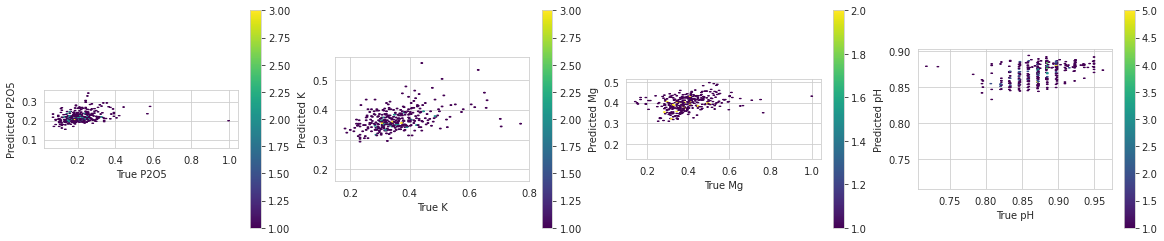

In [271]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.set_aspect('equal')

    img = ax.hexbin(y_v[:, i], y_hat[:, i], cmap='viridis', mincnt=1)

    ax.plot(np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])),
            np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])), 'r--')

    plt.colorbar(img, ax=ax)

    ax.set_xlabel('True ' + cols[i])
    ax.set_ylabel('Predicted ' + cols[i])

In [267]:
X_test = load_data(test_data)
X_test = preprocess(X_test)

predictions = []

for rf in random_forests:
    pp = rf.predict(X_test)
    predictions.append(pp)
    
predictions = np.asarray(predictions)
print(predictions.shape)

predictions = np.mean(predictions, axis=0) 
predictions =predictions * np.array([325.0, 625.0, 400.0, 7.8])

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")

(5, 1154, 4)


In [268]:
submission

,P,K,Mg,pH
0,67.3900,214.9620,152.5632,6.88900
1,71.9258,220.0180,154.1204,6.87362
2,68.3074,224.8262,171.5262,6.85928
3,73.5384,233.1260,169.2686,6.83480
4,70.6984,221.5402,159.8574,6.84426
...,...,...,...,...
1149,55.7578,191.9680,145.7020,6.61738
1150,55.6548,198.1000,145.2514,6.62810
1151,78.7222,231.9660,156.7642,6.65614
1152,59.0102,197.4520,147.5632,6.65520


In [204]:
y_b.shape

(346, 4)

In [205]:
from sklearn.decomposition import NMF
X = np.random.randint(0, 100, size=(150, 11, 11))
model = NMF(n_components=3, init='random', random_state=0)
W = model.fit_transform(X)

ValueError: Found array with dim 3. Estimator expected <= 2.